['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
['greedy-ppr-kg', 'greedy-ppr-joint', 'greedy-ppr-collab'] [0.2239258643236721, 0.3633655140217059, 0.37676770524805614] [0.012667984814901117, 0.005075265570921121, 0.013790142856452947]
['greedy-ppr-kg-rec', 'greedy-ppr-joint-rec', 'greedy-ppr-collab-rec'] [0.1952300025540773, 0.34609168262553525, 0.37631443802604203] [0.014420904098491501, 0.012829815458006957, 0.019679268596179977]
[0.21845958317134748, 0.1798291162368665, 0.18782245072640846, 0.1948088600816868]
[0.22905095924968444, 0.23726645195580037, 0.20313484921518304, 0.22625119687402048]
[

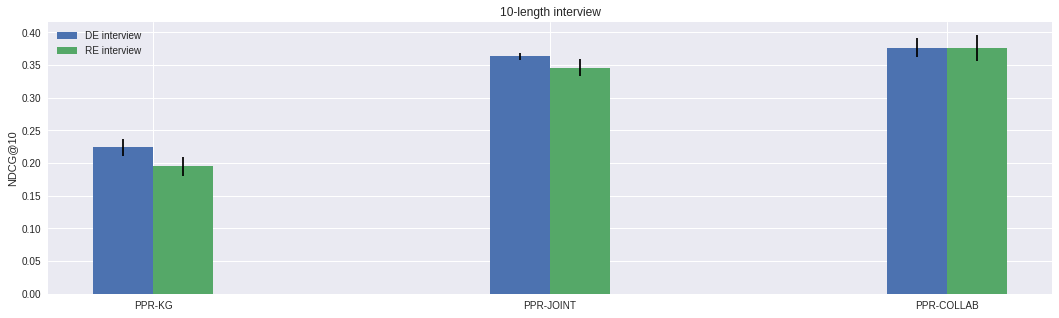

In [8]:
from requests import get
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_rel

plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn')
print(plt.style.available)
metric = 'ndcg'
cutoff = '10'
n_questions = 10
significance_level = 0.05

data = get(f'https://mindreader.tech/spectate/results/170k_uniform/{metric}/{cutoff}').json()
#data = get(f'http://localhost:5000/spectate/results/170k_equal_20/{metric}/{cutoff}').json()

models = sorted([key for key in data.keys() if key.endswith('-rec')], reverse=True)

fig, ax = plt.subplots(figsize=(18, 5))
ind = np.arange(len(models))

width = 0.15

# add with rec
for idx, (label, to_replace) in enumerate([('DE interview', '-rec'), ('RE interview', '')]):
    x = [model.replace(to_replace, '') for model in models]
    y = [np.mean(data[model][n_questions - 1]) for model in x]
    y_std = [np.std(data[model][n_questions - 1]) for model in x]
    
    print(x, y, y_std)
    ax.bar(ind + idx * width, y, yerr=y_std, width=width, label=label)


def get_postfix(model):
    re_data = f'{model}-rec'
    if re_data not in data:
        return ''
    
    re = data[re_data][n_questions - 1]
    de = data[model][n_questions - 1]
    
    print(re)
    print(de)
    
    t, p_value = ttest_rel(re, de)
    if p_value <= significance_level:
        return '*'
    
    return ''
        
# add statistical significance
models = [model.replace('-rec', '') for model in models]
models = [model.replace('greedy-', '').upper() + get_postfix(model) for model in models]


ax.set_xticks(ind + width / 2)
ax.set_xticklabels([model.replace('-rec', '').replace('greedy-', '').upper() for model in models])
plt.ylabel(f'{metric.upper()}@{cutoff}')
plt.title(f'{n_questions}-length interview')
plt.legend(loc='upper left')
plt.savefig('re_vs_de.pdf', bbox_inches='tight')
plt.show()